# Import dependencies

In [108]:
import cleverhans
from cleverhans.attacks import ProjectedGradientDescent
from cleverhans.attacks import FastGradientMethod
from cleverhans.model import Model as CleverhansModel

from io import BytesIO

import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import requests
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)

# Define model wrapper for cleverhans

In [3]:
class InceptionV1Model(CleverhansModel):
    SCOPE = 'inceptionv1'
    SOFTMAX_OP = 'softmax2'
  
    def __init__(self):
        super(InceptionV1Model, self).__init__()
        self._model = models.InceptionV1()
        self._model.load_graphdef()
        self._fprop_cache = dict()

    def fprop(self, x):
        if x not in self._fprop_cache:
            # https://github.com/tensorflow/lucid/blob/67e19f38c315e548034c3e4315dfee6f718df916/lucid/modelzoo/vision_base.py#L189
            graph = x.graph
            scope = graph.unique_name(
              '%sfprop%d' % (self.SCOPE, len(self._fprop_cache)), False)
            _, x_prep = self._model.create_input(x, forget_xy_shape=True)
            final_input_map = {self._model.input_name: x_prep}
            ops = tf.import_graph_def(self._model.graph_def, final_input_map,
                                    return_elements=[self.SOFTMAX_OP], name=scope)
            self._model.post_import(scope)

            softmax2_op = ops[0]
            logits = softmax2_op.inputs[0]
            logits = logits[:, :1000]

            self._fprop_cache[x] = {'logits' : logits}

        return self._fprop_cache[x]

# Define utility functions

In [4]:
def load_image_from_url(img_url, resize_to=(224, 224)):
    img_response = requests.get(img_url)
    img = Image.open(BytesIO(img_response.content))
    if resize_to is not None:
        img = img.resize(resize_to)
    img = np.array(img)
    return img

In [5]:
def load_image_from_file(filepath):
    img = image.load_img(filepath, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    return img

In [6]:
def get_predictions(model, imgs):
    graph = tf.Graph()
    with tf.Session(graph=graph) as sess:  
        x = tf.placeholder(tf.float32, (None, 224, 224, 3))
        y = model.get_probs(x)
        y = tf.arg_max(y, 1)
        y_eval = sess.run(y, feed_dict={x: imgs})

    return y_eval

In [7]:
def attack_images(model, imgs, attack_type="FGM", attack_kwargs={'eps': 0.3, 'y_target': 0}):
    graph = tf.Graph()
    with tf.Session(graph=graph) as sess:
        x = tf.placeholder(tf.float32, (None, 224, 224, 3))

        if attack_type == "FGM":
            attack = FastGradientMethod(model, sess=sess)
            
            ########################################################################
            # NEED TO CROSS CHECK IF IT IS RIGHT
            y_target_vec = np.zeros((len(imgs), 1000))
            y_target_vec[np.arange(len(imgs)), attack_kwargs['y_target']] = 1
            attack_kwargs['y_target'] = y_target_vec
            ########################################################################
            
        elif attack_type == "PGD":
            attack = ProjectedGradientDescent(model, sess=sess)
        
        adv_imgs = attack.generate(x, **attack_kwargs)
        adv_imgs_eval = sess.run(adv_imgs, feed_dict={x: imgs})

    return adv_imgs_eval

# Initialize model and load image

In [8]:
model = InceptionV1Model()

In [107]:
# Get an input image from url
panda_urls = []
correct_class_name = 'giant_panda'

# Panda1
img_url = ('https://cbsnews1.cbsistatic.com/hub/i/2016/08/26/cdf56aa8-1f2a-4d44-8cac-ab5993ee7d18/gettyimages-594359398.jpg')
panda_urls.append(img_url)

# Panda2
img_url = ('https://media.nature.com/w800/magazine-assets/d41586-019-00301-y/d41586-019-00301-y_16427380.jpg')
panda_urls.append(img_url)

# Panda3
img_url = ('https://nationalzoo.si.edu/sites/default/files/animals/giantpanda-001.jpg')
panda_urls.append(img_url)

# Experiments

### Get class-name mapping

In [110]:
label_df = pd.read_csv('../data/imagenet_tfrecords_labels.txt', sep=' ', names=['syn', 'label', 'name'])
label_dict = {int(label): name for label, name in zip(label_df['label'], label_df['name'])}

### Get prediction on benign images and save them

giant_panda 169


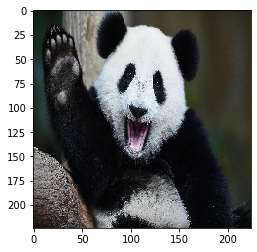

giant_panda 169


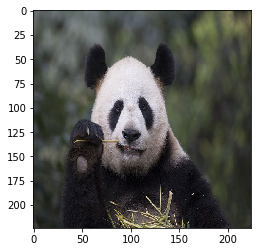

giant_panda 169


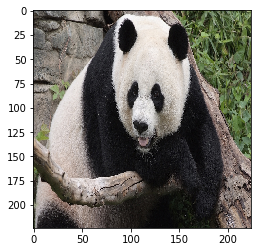

In [115]:
benign_imgs = []

for i, img_url in enumerate(panda_urls):
    # Get prediction
    img = load_image_from_url(img_url)
    predicted_class = get_predictions(model, [img])[0]
    predicted_class_name = label_dict[predicted_class]
    
    # Collect the benign img
    benign_imgs.append(img)
    
    # print out the results
    print(predicted_class_name, predicted_class)
    plt.imshow(img)
    plt.show()
    
    # Save the image
    filename = '../data/sample-images/sample-benign/benign-{}-{}.jpg'.format(correct_class_name, i)
    cv2.imwrite(filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

### Generate attacked images with different strength and save them

0-th image, predicted as armadillo, eps=2


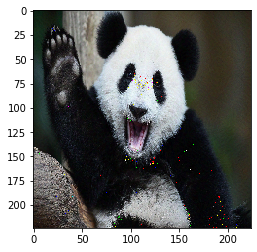

1-th image, predicted as armadillo, eps=2


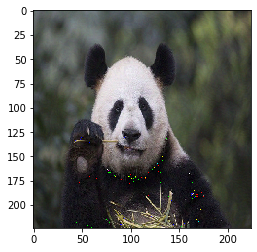

2-th image, predicted as armadillo, eps=2


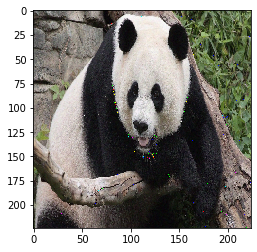

0-th image, predicted as armadillo, eps=2.5


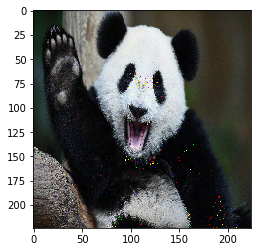

1-th image, predicted as armadillo, eps=2.5


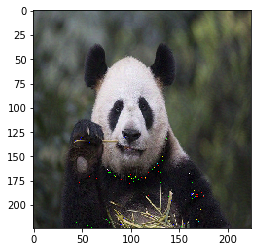

2-th image, predicted as armadillo, eps=2.5


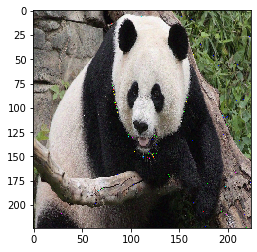

0-th image, predicted as armadillo, eps=3


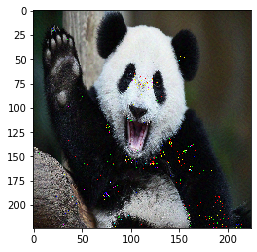

1-th image, predicted as armadillo, eps=3


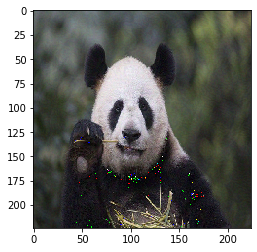

2-th image, predicted as armadillo, eps=3


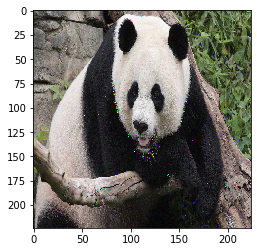

0-th image, predicted as armadillo, eps=3.5


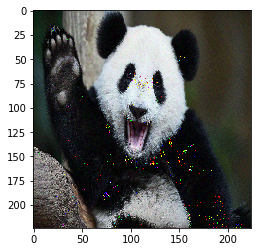

1-th image, predicted as armadillo, eps=3.5


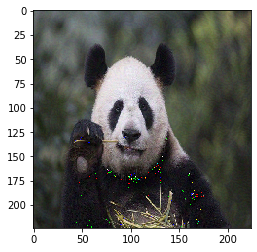

2-th image, predicted as armadillo, eps=3.5


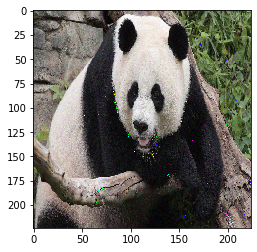

In [119]:
# Target to armadillo
target_label = 178

# Different attack strength
eps_list = [2, 2.5, 3, 3.5]

for eps in eps_list:
    
    # Generate attacked images
    adv_imgs = attack_images(model, benign_imgs, attack_type="FGM", attack_kwargs={'eps': eps, 'y_target': target_label})
    
    # Save the attacked images
    for i, adv_img in enumerate(adv_imgs):
        
        # Get the predicted class
        predicted_class = get_predictions(model, [adv_img])[0]
        predicted_class_name = label_dict[predicted_class]

        # Display the attacked image
        attacked_img = np.array(adv_img, dtype=np.uint8)
        print('{}-th image, predicted as {}, eps={}'.format(i, predicted_class_name, eps))
        plt.imshow(attacked_img)
        plt.show()

        # Save the attacked image if it the targeted attack succeed
        if target_label == predicted_class:
            filename = '../data/sample-images/sample-attacked/attacked-{}-{}-{}-{}'.format(correct_class_name, predicted_class_name, eps, i)
            np.save(filename, adv_img)
            cv2.imwrite(filename + '.jpg', cv2.cvtColor(attacked_img, cv2.COLOR_RGB2BGR))